# Stock Analysis:

## Executive Summary

This project explores stock analysis through traditional statistical approaches and machine learning techniques. We examine a diverse portfolio of technology and energy stocks to understand price movements, volatility patterns, risk metrics, and predictive relationships.

### Key Objectives:
1. **Time Series Analysis**: Implement ARIMA and GARCH models for price forecasting and volatility estimation
2. **Machine Learning**: Deploy Random Forest and LSTM neural networks for price prediction
3. **Risk Assessment**: Calculate comprehensive risk metrics including VaR, Sharpe ratios, and maximum draw down
4. **Portfolio Optimization**: Determine optimal asset allocation with modern portfolio theory

### Dataset:
We analyze 7 stocks across technology and energy sectors over a one-year period, including Apple (AAPL), Google (GOOG), Microsoft (MSFT), Tesla (TSLA), ExxonMobil (XOM), Chevron (CVX), and ConocoPhillips (COP).

## 1. Environment Setup and Data Acquisition

We begin by importing the necessary libraries for data manipulation, visualization, statistical modeling, and machine learning.

In [5]:
# Data manipulation and numerical computing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Data acquisition 
import yfinance as yf
from pandas_datareader import data as web

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Time series and statistical modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

# Machine learning
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, classification_report, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Deep learning
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available. LSTM models will be skipped.")

print("Libraries loaded successfully!")
print(f"TensorFlow available: {TENSORFLOW_AVAILABLE}")

2026-01-10 23:19:01.899093: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-10 23:19:01.952142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries loaded successfully!
TensorFlow available: True


### 1.1 Data Collection

We retrieve historical stock data for our portfolio using the yfinance API, which provides adjusted closing prices, volume, and other essential metrics.

In [45]:
# Define stock list
stock_list = ['AAPL', 'GOOG', 'MSFT', 'TSLA', 'XOM', 'CVX', 'COP', 'NVDA']

# Fix the date range - get PAST data
end_date = datetime.now()
start_date = end_date - timedelta(days=365)  #Get 1 year of historical data

print(f"Fetching data from {start_date.date()} to {end_date.date()}")
print(f"Stocks: {', '.join(stock_list)}\n")

# Download data using yfinance
data = yf.download(stock_list, start=start_date, end=end_date, progress=False)

# Check the structure and extract closing prices
print("Columns:", data.columns.tolist()[:10])  # Print first 10 columns to see structure

# Extract closing prices
if isinstance(data.columns, pd.MultiIndex):
    # Multi-stock download has MultiIndex columns
    if 'Adj Close' in data.columns.get_level_values(0):
        closing_prices = data['Adj Close']
    elif 'Close' in data.columns.get_level_values(0):
        closing_prices = data['Close']
    else:
        # Fallback: get all columns and filter
        closing_prices = data.xs('Close', axis=1, level=0)
else:
    # Single stock or already filtered
    closing_prices = data

print(f"\nTotal dataset shape: {closing_prices.shape}")
print(f"Date range: {closing_prices.index[0].date()} to {closing_prices.index[-1].date()}")
print(f"\nFirst few rows:")
print(closing_prices.head())
print(f"\nLast few rows:")
print(closing_prices.tail())


Fetching data from 2025-01-11 to 2026-01-11
Stocks: AAPL, GOOG, MSFT, TSLA, XOM, CVX, COP, NVDA

Columns: [('Close', 'AAPL'), ('Close', 'COP'), ('Close', 'CVX'), ('Close', 'GOOG'), ('Close', 'MSFT'), ('Close', 'NVDA'), ('Close', 'TSLA'), ('Close', 'XOM'), ('High', 'AAPL'), ('High', 'COP')]

Total dataset shape: (250, 8)
Date range: 2025-01-13 to 2026-01-09

First few rows:
Ticker            AAPL         COP         CVX        GOOG        MSFT  \
Date                                                                     
2025-01-13  233.344620  100.744904  148.467514  191.544312  414.135040   
2025-01-14  232.229675  101.373169  149.948837  190.309113  412.626160   
2025-01-15  236.799011  101.953110  151.315506  196.216110  423.188232   
2025-01-16  227.232285  102.078751  152.318970  193.656082  421.470886   
2025-01-17  228.944519  102.310730  154.316376  196.783905  425.888306   

Ticker            NVDA        TSLA         XOM  
Date                                            
2025-01

## 2. Exploratory Data Analysis

Before building predictive models, we must understand the fundamental characteristics of our data through visualization and summary statistics.

### 2.1 Price Evolution and Volume Trends

Examining historical price movements reveals secular trends, cyclical patterns, and discrete events that impact stock valuations.

In [46]:
# Displaying sample data
print("Sample of Microsoft (MSFT) data:")
print(closing_prices['MSFT'].head(10))
print(f"\nBasic statistics for MSFT:")
print(closing_prices['MSFT'].describe())

Sample of Microsoft (MSFT) data:
Date
2025-01-13    414.135040
2025-01-14    412.626160
2025-01-15    423.188232
2025-01-16    421.470886
2025-01-17    425.888306
2025-01-21    425.362183
2025-01-22    442.932587
2025-01-23    443.438843
2025-01-24    440.808228
2025-01-27    431.377808
Name: MSFT, dtype: float64

Basic statistics for MSFT:
count    250.000000
mean     464.221616
std       50.611734
min      352.669373
25%      413.059059
50%      480.059998
75%      507.380379
max      541.057373
Name: MSFT, dtype: float64


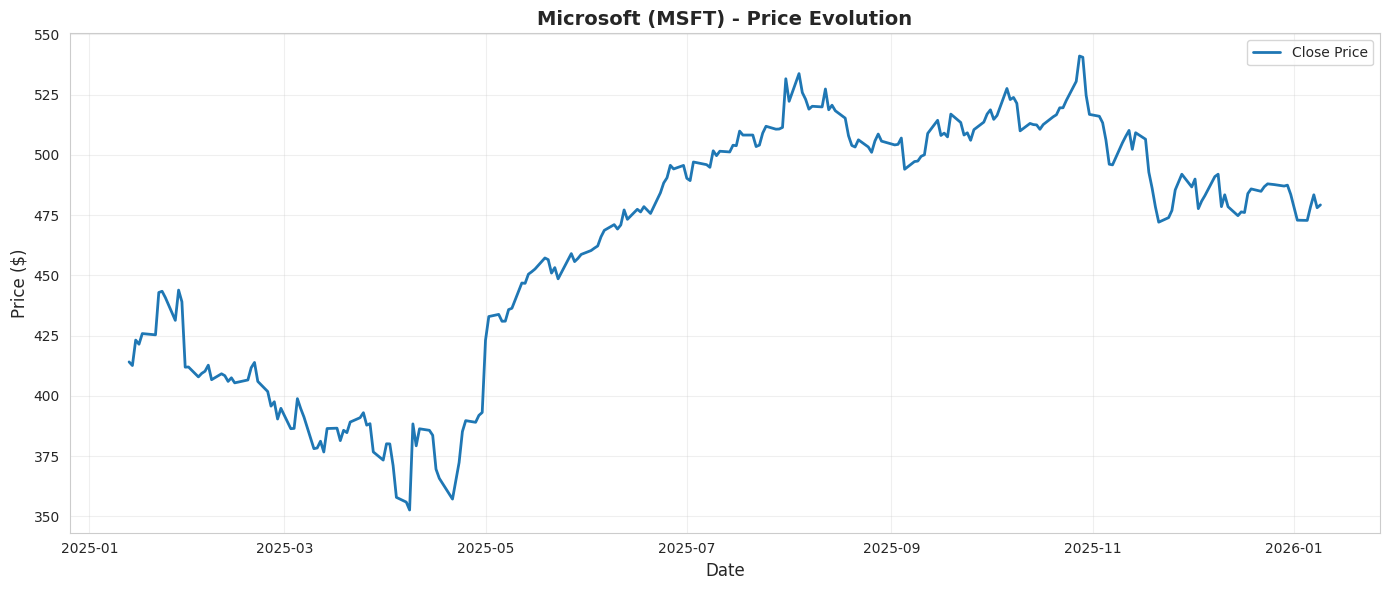

MSFT price range: $352.67 - $541.06
MSFT current price: $479.28
MSFT return over period: 15.73%


In [47]:
# Visualize price for MSFT
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Price plot
ax.plot(closing_prices.index, closing_prices['MSFT'], 
         linewidth=2, color='#1f77b4', label='Close Price')
ax.set_title('Microsoft (MSFT) - Price Evolution', fontsize=14, fontweight='bold')
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MSFT price range: ${closing_prices['MSFT'].min():.2f} - ${closing_prices['MSFT'].max():.2f}")
print(f"MSFT current price: ${closing_prices['MSFT'].iloc[-1]:.2f}")
print(f"MSFT return over period: {((closing_prices['MSFT'].iloc[-1] / closing_prices['MSFT'].iloc[0]) - 1) * 100:.2f}%")

### 2.2 Moving Averages and Trend Analysis

Moving averages smooth out short-term fluctuations to reveal underlying trends. We calculate 10-day, 20-day, and 50-day moving averages to identify different time-scale patterns.

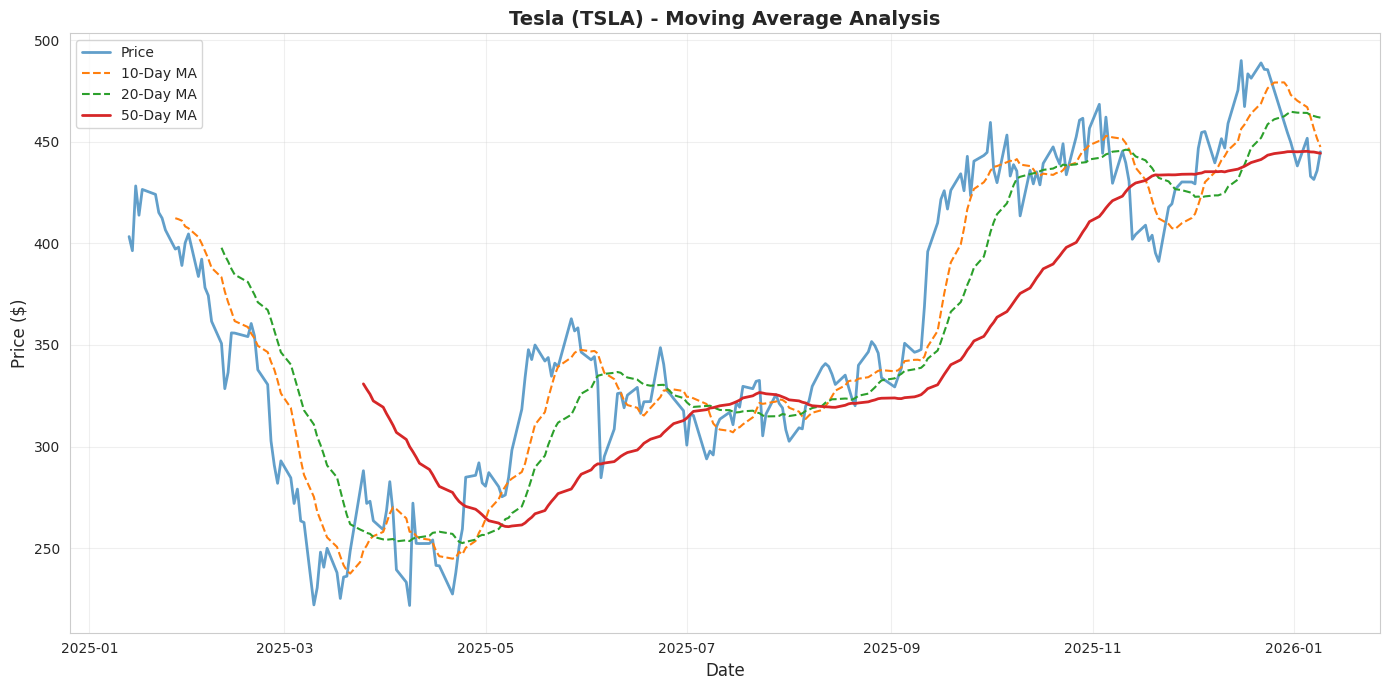

Moving averages help identify trend direction and potential support/resistance levels.
Current TSLA price: $445.01
50-Day MA: $444.26 - Price is above trend


In [48]:
tesla = closing_prices['TSLA'].to_frame(name='Price').copy()
tesla['MA10'] = tesla['Price'].rolling(window=10).mean()
tesla['MA20'] = tesla['Price'].rolling(window=20).mean()
tesla['MA50'] = tesla['Price'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
plt.plot(tesla.index, tesla['Price'], label='Price', linewidth=2, alpha=0.7)
plt.plot(tesla.index, tesla['MA10'], label='10-Day MA', linewidth=1.5, linestyle='--')
plt.plot(tesla.index, tesla['MA20'], label='20-Day MA', linewidth=1.5, linestyle='--')
plt.plot(tesla.index, tesla['MA50'], label='50-Day MA', linewidth=2, linestyle='-')
plt.title('Tesla (TSLA) - Moving Average Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Moving averages help identify trend direction and potential support/resistance levels.")
print(f"Current TSLA price: ${tesla['Price'].iloc[-1]:.2f}")
print(f"50-Day MA: ${tesla['MA50'].iloc[-1]:.2f} - Price is {'above' if tesla['Price'].iloc[-1] > tesla['MA50'].iloc[-1] else 'below'} trend")


### 2.3 Daily Returns Distribution

Daily returns measure the percentage change in price from one day to the next, providing insight into volatility and return characteristics.

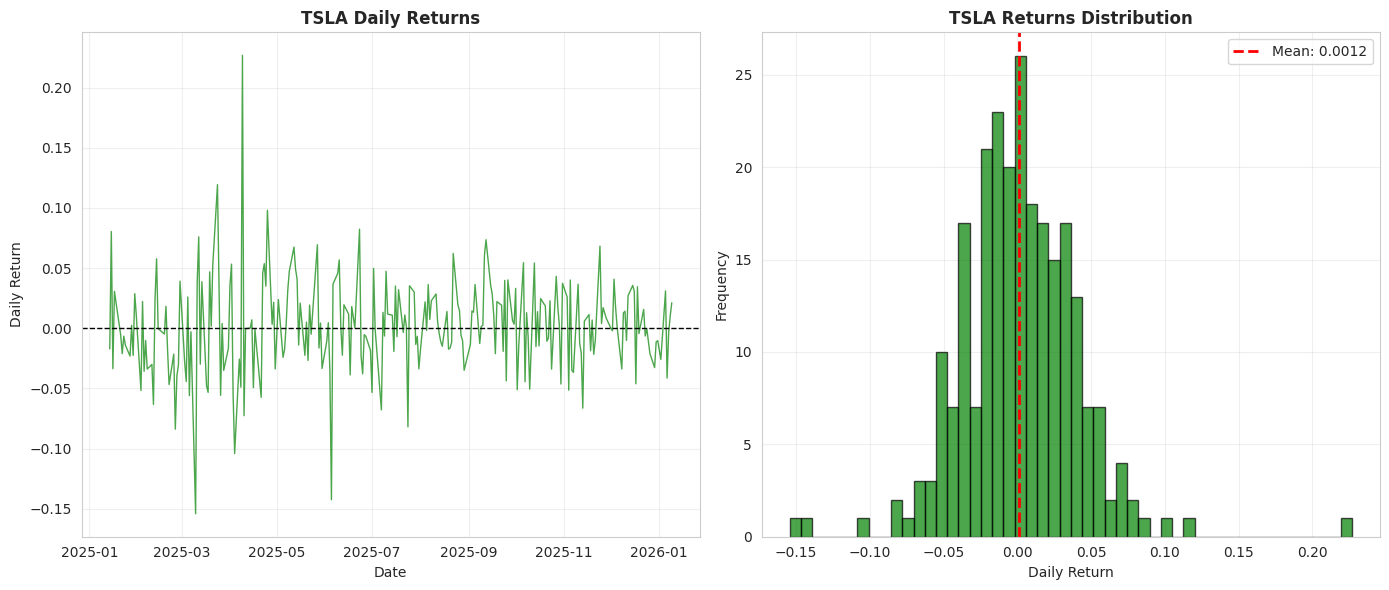

TSLA Returns Statistics:
  Mean: 0.0012 (29.55% annualized)
  Std Dev: 0.0396 (62.92% annualized)
  Min: -0.1543
  Max: 0.2269


In [49]:
# Calculate daily returns for all stocks
returns = closing_prices.pct_change().dropna()

# Visualize TSLA daily returns
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(returns.index, returns['TSLA'], linewidth=1, alpha=0.7, color='green')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('TSLA Daily Returns', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(returns['TSLA'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.axvline(x=returns['TSLA'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {returns["TSLA"].mean():.4f}')
plt.title('TSLA Returns Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("TSLA Returns Statistics:")
print(f"  Mean: {returns['TSLA'].mean():.4f} ({returns['TSLA'].mean()*252:.2%} annualized)")
print(f"  Std Dev: {returns['TSLA'].std():.4f} ({returns['TSLA'].std()*np.sqrt(252):.2%} annualized)")
print(f"  Min: {returns['TSLA'].min():.4f}")
print(f"  Max: {returns['TSLA'].max():.4f}")

### 2.4 Correlation Analysis

Understanding how different stocks move together is crucial for portfolio diversification. High correlation indicates stocks tend to move in tandem, while low or negative correlation suggests independent movements.

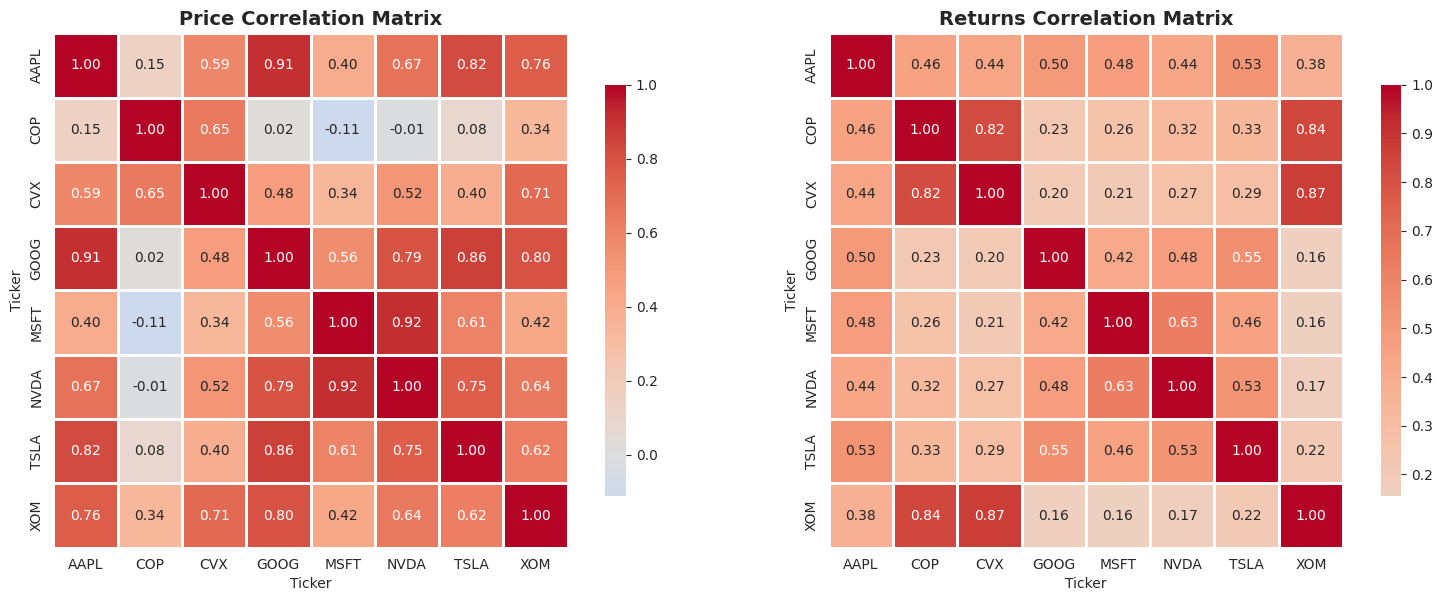


Key Observations:
Highest returns correlation: CVX & XOM = 0.868
Tech stocks (AAPL, GOOG, MSFT) show strong positive correlation
Energy stocks(XOM, CVX, COP) form a distinct cluster
Portfolio diversification benefit exists between tech and energy sectors


In [50]:


# Calculate correlation matrices
price_corr = closing_prices.corr()
returns_corr = returns.corr()

# Visualizing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Price correlation
sns.heatmap(price_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax1)
ax1.set_title('Price Correlation Matrix', fontsize=14, fontweight='bold')

# Returns correlation  
sns.heatmap(returns_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax2)
ax2.set_title('Returns Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

mask = np.tril(np.ones_like(returns_corr, dtype=bool))
upper = returns_corr.mask(mask)
best_pair = upper.stack().idxmax()
best_val = upper.stack().max()

print("\nKey Observations:")
print(f"Highest returns correlation: {best_pair[0]} & {best_pair[1]} = {best_val:.3f}")
print("Tech stocks (AAPL, GOOG, MSFT) show strong positive correlation")
print("Energy stocks(XOM, CVX, COP) form a distinct cluster")
print("Portfolio diversification benefit exists between tech and energy sectors")


## 3. Time Series Forecasting with ARIMA

ARIMA (Auto Regressive Integrated Moving Average) is a classical statistical method for time series forecasting. It captures temporal dependencies in the data through three components:
- **AR (p)**: Autoregressive terms - relationship between observation and lagged observations
- **I (d)**: Integration - differencing to make the series stationary
- **MA (q)**: Moving average terms - dependency between observation and lagged forecast errors

### 3.1 Stationarity Testing

Before fitting ARIMA models, we test for stationarity using the Augmented Dickey-Fuller test.

In [51]:
from statsmodels.tsa.stattools import adfuller

# Test stationarity for MSFT
def test_stationarity(series, name):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series.dropna())
    print(f'\nAugmented Dickey-Fuller Test Results for {name}:')
    print(f'  ADF Statistic: {result[0]:.6f}')
    print(f'  p-value: {result[1]:.6f}')
    print(f'  Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"  ✓ {name} is stationary (reject null hypothesis)")
        return True
    else:
        print(f"  ✗ {name} is NOT stationary (fail to reject null hypothesis)")
        return False

# Test price series
msft_prices = closing_prices['MSFT']
is_stationary = test_stationarity(msft_prices, 'MSFT Prices')

# Test returns
msft_returns = msft_prices.pct_change().dropna()
is_returns_stationary = test_stationarity(msft_returns, 'MSFT Returns')



Augmented Dickey-Fuller Test Results for MSFT Prices:
  ADF Statistic: -1.101900
  p-value: 0.714314
  Critical Values:
    1%: -3.457
    5%: -2.873
    10%: -2.573
  ✗ MSFT Prices is NOT stationary (fail to reject null hypothesis)

Augmented Dickey-Fuller Test Results for MSFT Returns:
  ADF Statistic: -10.058893
  p-value: 0.000000
  Critical Values:
    1%: -3.457
    5%: -2.873
    10%: -2.573
  ✓ MSFT Returns is stationary (reject null hypothesis)


### 3.2 ARIMA Model Fitting and Forecasting

We fit an ARIMA(1,0,1) model to Microsoft’s daily returns and forecast the next 30 trading days. We then convert the return forecasts into price forecasts and use Monte Carlo simulation from the fitted ARIMA model to generate a 95% prediction interval for future prices.


Fitting ARIMA model...

ARIMA Model Summary (Key Statistics):
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.667      0.505      -0.001       0.003
ar.L1         -0.0094      3.419     -0.003      0.998      -6.710       6.691
ma.L1         -0.0094      3.422     -0.003      0.998      -6.716       6.697
sigma2         0.0002   9.64e-06     24.275      0.000       0.000       0.000


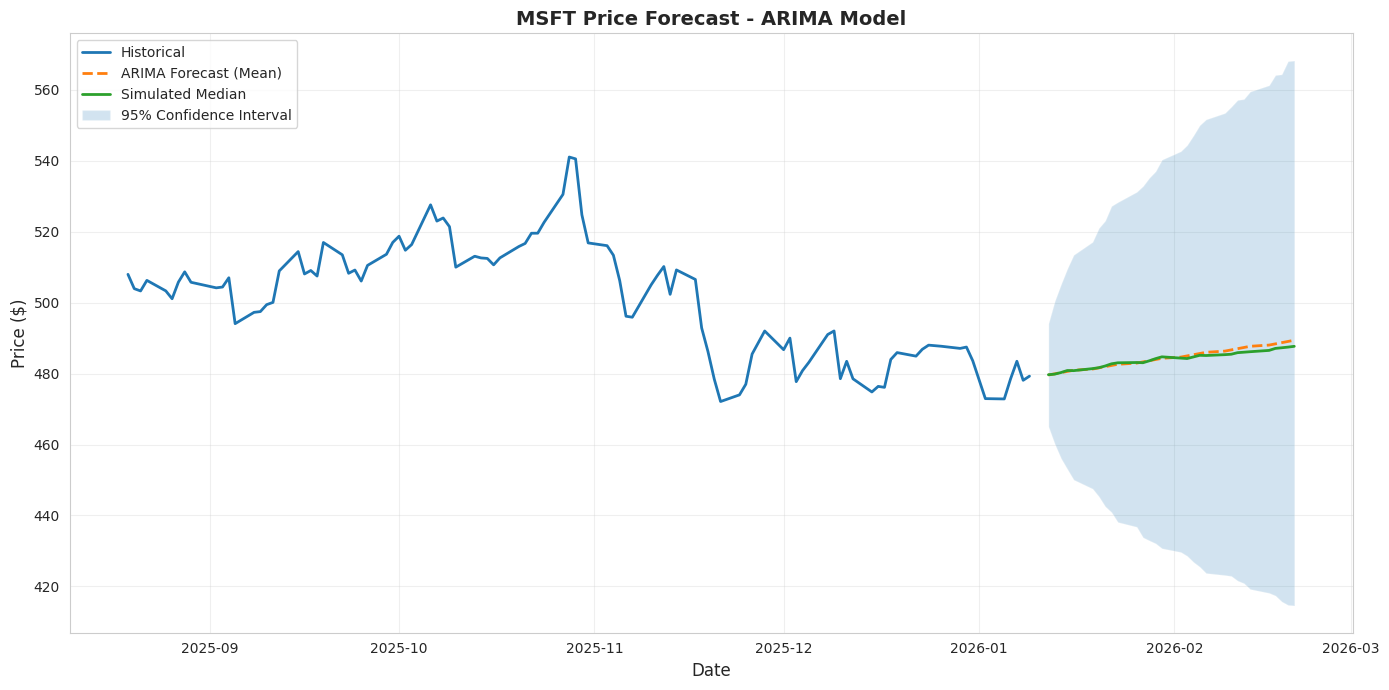


30-Day Forecast Summary:
  Current Price: $479.28
  Forecast Price (30 days, mean): $489.40
  Simulated Median (30 days): $487.69
  95% Interval (30 days): $414.62 to $568.25
  Expected Change (mean): 2.11%


In [52]:
# Fit ARIMA model
print("\nFitting ARIMA model...")
try:
    # Use returns (already stationary)
    # ARIMA(1,0,1) - AR(1), no differencing, MA(1)
    model = ARIMA(msft_returns, order=(1, 0, 1))
    arima_result = model.fit()
    
    print("\nARIMA Model Summary (Key Statistics):")
    print("="*60)
    print(arima_result.summary().tables[1])
    
    # Make forecasts
    forecast_steps = 30

    # Convert returns forecast to price forecast (mean path)
    forecast_res = arima_result.get_forecast(steps=forecast_steps)
    forecast_returns = forecast_res.predicted_mean
    
    last_price = msft_prices.iloc[-1]
    forecast_prices = []
    p = last_price
    for r in forecast_returns:
        p = p * (1 + r)
        forecast_prices.append(p)
    
    # Create forecast dates
    last_date = msft_prices.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                   periods=forecast_steps, freq='B')
    
    # Simulate many future return paths to build a realistic price CI
    sims = 5000
    sim_returns = arima_result.simulate(
        nsimulations=forecast_steps,
        anchor='end',
        repetitions=sims
    )
    price_paths = last_price * np.cumprod(1 + sim_returns, axis=0)
    
    lower_prices = np.percentile(price_paths, 2.5, axis=1)
    median_prices = np.percentile(price_paths, 50, axis=1)
    upper_prices = np.percentile(price_paths, 97.5, axis=1)
    
    # Visualize
    plt.figure(figsize=(14, 7))
    
    # Plot historical prices (last 100 days)
    historical_window = msft_prices.iloc[-100:]
    plt.plot(historical_window.index, historical_window.values,
             label='Historical', linewidth=2)
    
    # Plot forecast (mean compounded returns)
    plt.plot(forecast_dates, forecast_prices,
             label='ARIMA Forecast (Mean)', linewidth=2, linestyle='--')
    
    # Plot simulated median + 95% interval
    plt.plot(forecast_dates, median_prices,
             label='Simulated Median', linewidth=2)
    plt.fill_between(forecast_dates, lower_prices, upper_prices,
                     alpha=0.2, label='95% Confidence Interval')
    
    plt.title('MSFT Price Forecast - ARIMA Model', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n30-Day Forecast Summary:")
    print(f"  Current Price: ${last_price:.2f}")
    print(f"  Forecast Price (30 days, mean): ${forecast_prices[-1]:.2f}")
    print(f"  Simulated Median (30 days): ${median_prices[-1]:.2f}")
    print(f"  95% Interval (30 days): ${lower_prices[-1]:.2f} to ${upper_prices[-1]:.2f}")
    print(f"  Expected Change (mean): {((forecast_prices[-1]/last_price - 1)*100):.2f}%")
    
except Exception as e:
    print(f"Error fitting ARIMA model: {e}")


## 4. Volatility Modeling with GARCH

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models are designed to capture volatility clustering, meaning the tendency for large changes to follow large changes and small changes to follow small changes.

### 4.1 GARCH(1,1) Model for TSLA

Tesla is known for high volatility. We fit a GARCH(1,1) model to forecast future volatility.

Fitting GARCH(1,1) model for TSLA returns...
Sample size: 249 observations

GARCH Model Summary (Key Parameters):
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2021      0.226      0.896      0.370 [ -0.240,  0.644]


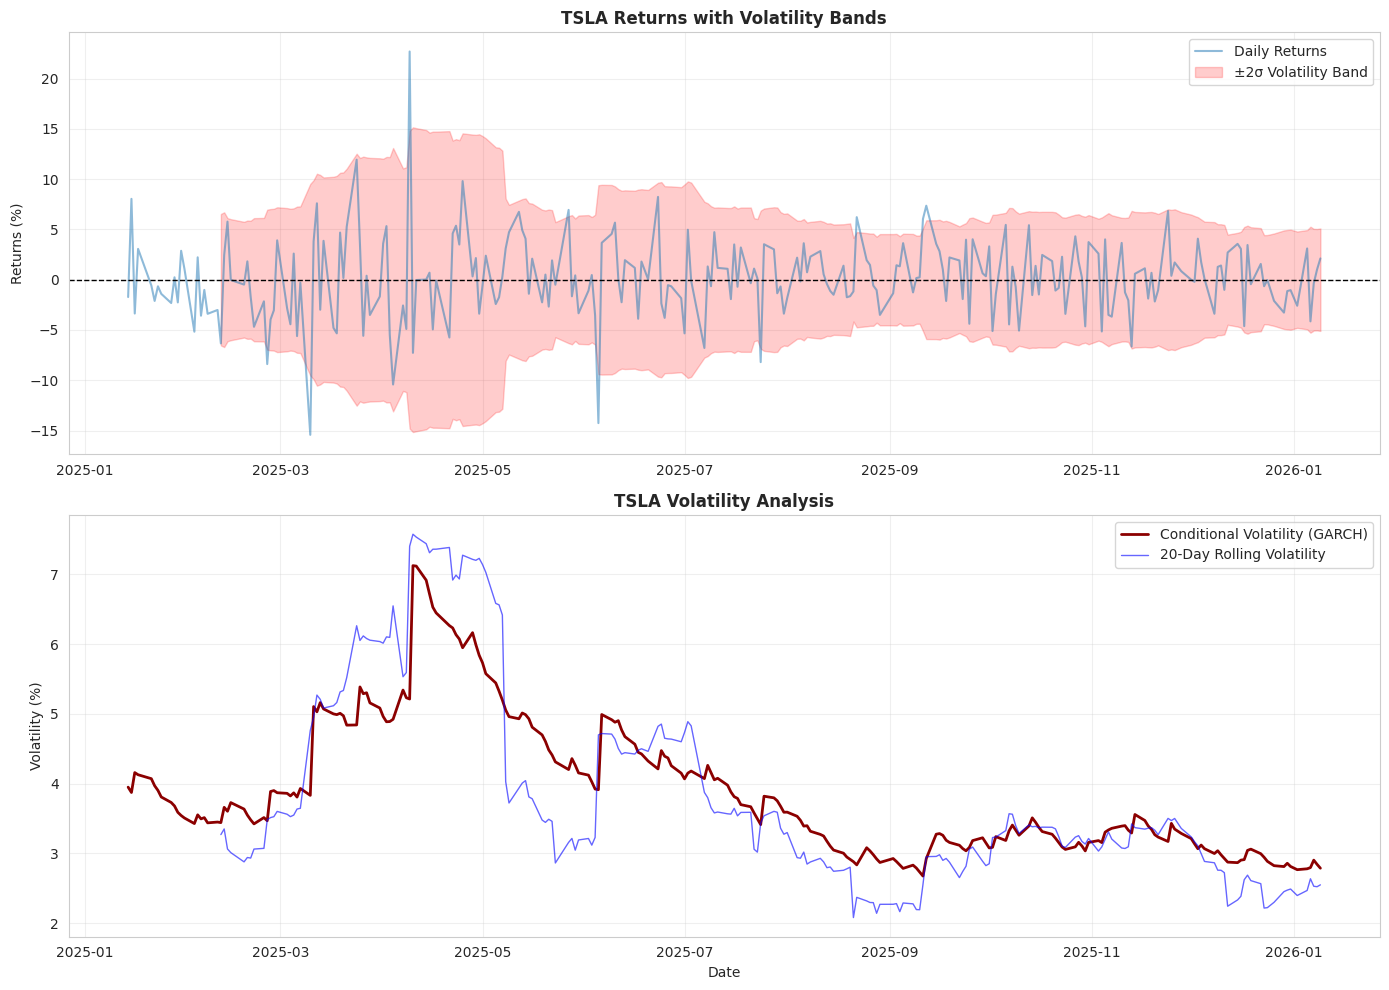


Volatility Forecast (next 30 days):
  Current volatility: 2.79%
  Forecasted volatility (day 1): 2.76%
  Forecasted volatility (day 30): 3.03%
  Mean forecasted volatility: 2.90%
  Annualized volatility: 46.11%


In [53]:
# Prepare returns data (GARCH requires percentage returns)
tsla_returns = closing_prices['TSLA'].pct_change().dropna() * 100  # Convert to percentage

print(f"Fitting GARCH(1,1) model for TSLA returns...")
print(f"Sample size: {len(tsla_returns)} observations")

try:
    # Fit GARCH(1,1) model
    garch_model = arch_model(tsla_returns, vol='Garch', p=1, q=1)
    garch_result = garch_model.fit(disp='off')
    
    print("\nGARCH Model Summary (Key Parameters):")
    print("="*60)
    print(garch_result.summary().tables[1])
    
    # Forecast volatility
    forecast_horizon = 30
    garch_forecast = garch_result.forecast(horizon=forecast_horizon)
    
    # Extract forecasted variance and convert to volatility (std dev)
    forecast_variance = garch_forecast.variance.values[-1, :]
    forecast_volatility = np.sqrt(forecast_variance)
    
    # Calculate historical rolling volatility for comparison
    rolling_vol = tsla_returns.rolling(window=20).std()
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Returns with volatility bands
    ax1.plot(tsla_returns.index, tsla_returns, alpha=0.5, label='Daily Returns')
    ax1.fill_between(tsla_returns.index, -rolling_vol*2, rolling_vol*2, 
                      alpha=0.2, color='red', label='±2σ Volatility Band')
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax1.set_title('TSLA Returns with Volatility Bands', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Returns (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
        # Conditional volatility
    conditional_vol = garch_result.conditional_volatility
    ax2.plot(conditional_vol.index, conditional_vol, 
             label='Conditional Volatility (GARCH)', linewidth=2, color='darkred')
    ax2.plot(rolling_vol.index, rolling_vol, 
             label='20-Day Rolling Volatility', linewidth=1, alpha=0.6, color='blue')
    ax2.set_title('TSLA Volatility Analysis', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volatility (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVolatility Forecast (next 30 days):")
    print(f"  Current volatility: {conditional_vol.iloc[-1]:.2f}%")
    print(f"  Forecasted volatility (day 1): {forecast_volatility[0]:.2f}%")
    print(f"  Forecasted volatility (day 30): {forecast_volatility[-1]:.2f}%")
    print(f"  Mean forecasted volatility: {forecast_volatility.mean():.2f}%")
    
    # Annualized volatility
    ann_vol = forecast_volatility.mean() * np.sqrt(252)
    print(f"  Annualized volatility: {ann_vol:.2f}%")
    
except Exception as e:
    print(f"Error fitting GARCH model: {e}")
    print("This may occur if returns don't exhibit enough volatility clustering.")


## 5. Machine Learning for Stock Prediction

Moving beyond traditional statistical methods, we employ machine learning algorithms that can capture non-linear relationships and complex patterns in the data.

### 5.1 Feature Engineering

Creating informative features is crucial for ML model performance. We engineer technical indicators and lagged features.

In [54]:
# Feature engineering for MSFT
def create_features(df, stock_name):
    """Create technical indicators and features for ML"""
    data = df.copy()

    price_col = 'Adj Close' if 'Adj Close' in data.columns else ('Close' if 'Close' in data.columns else None)
    if price_col is None:
        raise KeyError(f"{stock_name}: Need 'Adj Close' or 'Close' column. Found: {list(data.columns)}")

    # Price-based features
    data['Returns'] = data[price_col].pct_change()
    data['Log_Returns'] = np.log(data[price_col] / data[price_col].shift(1))

    # Moving averages
    data['MA5'] = data[price_col].rolling(window=5).mean()
    data['MA10'] = data[price_col].rolling(window=10).mean()
    data['MA20'] = data[price_col].rolling(window=20).mean()
    data['MA50'] = data[price_col].rolling(window=50).mean()

    # Moving average ratios
    data['MA5_MA20_ratio'] = data['MA5'] / data['MA20']
    data['MA10_MA50_ratio'] = data['MA10'] / data['MA50']

    # Volatility (rolling standard deviation)
    data['Volatility_10'] = data['Returns'].rolling(window=10).std()
    data['Volatility_20'] = data['Returns'].rolling(window=20).std()

    # Relative Strength Index (RSI)
    delta = data[price_col].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD (Moving Average Convergence Divergence)
    exp1 = data[price_col].ewm(span=12, adjust=False).mean()
    exp2 = data[price_col].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    data['BB_middle'] = data[price_col].rolling(window=20).mean()
    bb_std = data[price_col].rolling(window=20).std()
    data['BB_upper'] = data['BB_middle'] + (bb_std * 2)
    data['BB_lower'] = data['BB_middle'] - (bb_std * 2)
    data['BB_width'] = (data['BB_upper'] - data['BB_lower']) / data['BB_middle']

    # Price momentum
    data['Momentum_5'] = data[price_col] - data[price_col].shift(5)
    data['Momentum_10'] = data[price_col] - data[price_col].shift(10)

    # Volume indicators
    if 'Volume' in data.columns:
        data['Volume_MA5'] = data['Volume'].rolling(window=5).mean()
        data['Volume_ratio'] = data['Volume'] / data['Volume_MA5']

    # Target variable: 1 if price goes up next day, 0 if down
    data['Target'] = (data[price_col].shift(-1) > data[price_col]).astype(int)

    return data.dropna(), price_col


# Create features for MSFT (use the original yfinance download `data`, not `closing_prices`)
if isinstance(data.columns, pd.MultiIndex):
    msft_df = data.xs('MSFT', axis=1, level=1).copy()   # columns like Open/High/Low/Close/Adj Close/Volume
else:
    msft_df = data.copy()

msft_features, price_col = create_features(msft_df, 'MSFT')

print("Feature engineering complete!")
print(f"Original columns: {len(msft_df.columns)}")
print(f"Engineered features: {len(msft_features.columns)}")
print("\nSample of engineered features:")
print(msft_features[[price_col, 'MA20', 'RSI', 'MACD', 'BB_width', 'Target']].head(10))
print(f"\nData shape: {msft_features.shape}")


Feature engineering complete!
Original columns: 5
Engineered features: 27

Sample of engineered features:
Price            Close        MA20        RSI      MACD  BB_width  Target
Date                                                                     
2025-03-25  393.052856  387.679683  44.875818 -4.274113  0.066196       0
2025-03-26  387.890564  387.194284  44.059074 -3.978637  0.061758       1
2025-03-27  388.497284  387.097305  47.530266 -3.653398  0.061362       0
2025-03-28  376.780090  386.192654  48.738371 -4.291653  0.062851       0
2025-03-31  373.388336  385.541150  45.562978 -5.013369  0.069599       1
2025-04-01  380.152008  385.221861  49.114720 -4.982132  0.070708       0
2025-04-02  380.102295  384.282895  52.979666 -4.904848  0.063317       0
2025-04-03  371.120422  383.100233  36.153363 -5.504904  0.065084       0
2025-04-04  357.921173  381.435654  29.062574 -6.965231  0.085092       0
2025-04-07  355.951752  380.326598  30.477698 -8.187092  0.104197       0

Data 

### 5.2 Random Forest Classifier - Price Direction Prediction

Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions. We use it to predict whether the stock price will rise or fall the next day.

Total samples: 201
Features used: ['Returns', 'MA5_MA20_ratio', 'MA10_MA50_ratio', 'Volatility_10', 'Volatility_20', 'RSI', 'MACD', 'BB_width', 'Momentum_5', 'Momentum_10', 'Volume_ratio']

Training Random Forest with walk-forward validation...
Fold 01 | Train:  120 Test:  20 | Acc: 65.00% Prec(Up): 66.67% Rec(Up): 72.73%
Fold 02 | Train:  140 Test:  20 | Acc: 60.00% Prec(Up): 60.00% Rec(Up): 60.00%
Fold 03 | Train:  160 Test:  20 | Acc: 50.00% Prec(Up): 54.55% Rec(Up): 54.55%
Fold 04 | Train:  180 Test:  20 | Acc: 55.00% Prec(Up): 54.55% Rec(Up): 60.00%

Model Performance (Walk-Forward Overall):
  Accuracy: 57.50%
  Baseline (majority class): 52.50%
  Precision (Up=1): 59.09%
  Recall (Up=1): 61.90%
  F1 (Up=1): 60.47%
  ROC AUC: 0.565

Confusion Matrix (rows=true, cols=pred):
[[20 18]
 [16 26]]

Classification Report (Overall):
              precision    recall  f1-score   support

        Down       0.56      0.53      0.54        38
          Up       0.59      0.62      0.60      

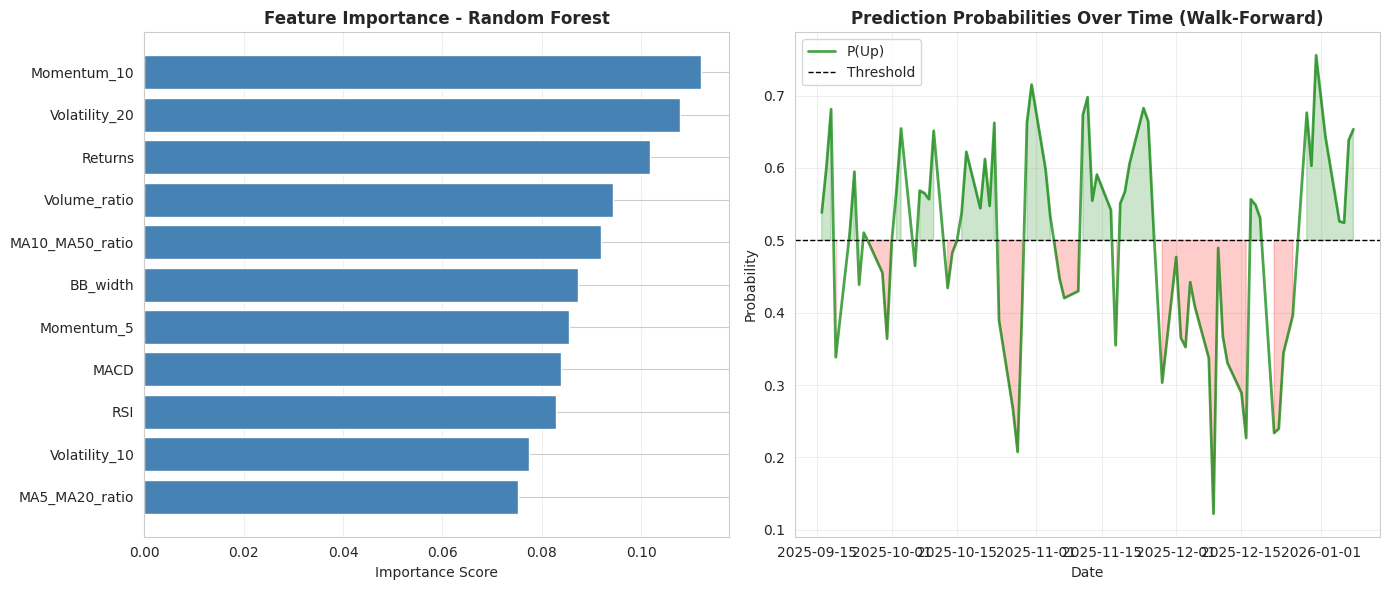


Key Insights:
Top predictive feature: Momentum_10
Model beats random guessing by 7.5 percentage points


In [55]:
# Prepare data for classification
feature_cols = ['Returns', 'MA5_MA20_ratio', 'MA10_MA50_ratio',
                'Volatility_10', 'Volatility_20', 'RSI', 'MACD',
                'BB_width', 'Momentum_5', 'Momentum_10', 'Volume_ratio']

feature_cols = [c for c in feature_cols if c in msft_features.columns]

X = msft_features[feature_cols]
y = msft_features['Target']

print(f"Total samples: {len(X)}")
print(f"Features used: {feature_cols}")

# Walk-forward validation (expanding window)
print("\nTraining Random Forest with walk-forward validation...")

test_window = max(20, int(len(X) * 0.1))  # ~10% chunks, at least 20 days
start_train = max(100, int(len(X) * 0.6)) # start after enough history
step = test_window

all_true = []
all_pred = []
all_proba = []
all_dates = []

fold = 1
for train_end in range(start_train, len(X) - test_window + 1, step):
    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_test, y_test = X.iloc[train_end:train_end + test_window], y.iloc[train_end:train_end + test_window]

    rf_classifier = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced_subsample'
    )
    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)
    y_proba = rf_classifier.predict_proba(X_test)[:, 1]

    all_true.append(y_test.values)
    all_pred.append(y_pred)
    all_proba.append(y_proba)
    all_dates.append(y_test.index)

    fold_acc = accuracy_score(y_test, y_pred)
    fold_prec = precision_score(y_test, y_pred, zero_division=0)
    fold_rec = recall_score(y_test, y_pred, zero_division=0)
    print(f"Fold {fold:02d} | Train: {len(X_train):4d} Test: {len(X_test):3d} | "
          f"Acc: {fold_acc:.2%} Prec(Up): {fold_prec:.2%} Rec(Up): {fold_rec:.2%}")
    fold += 1

y_true_all = np.concatenate(all_true)
y_pred_all = np.concatenate(all_pred)
y_proba_all = np.concatenate(all_proba)
dates_all = np.concatenate([d.values for d in all_dates])

accuracy = accuracy_score(y_true_all, y_pred_all)
precision_up = precision_score(y_true_all, y_pred_all, zero_division=0)
recall_up = recall_score(y_true_all, y_pred_all, zero_division=0)
f1_up = f1_score(y_true_all, y_pred_all, zero_division=0)

baseline = max(y_true_all.mean(), 1 - y_true_all.mean())

print("\nModel Performance (Walk-Forward Overall):")
print(f"  Accuracy: {accuracy:.2%}")
print(f"  Baseline (majority class): {baseline:.2%}")
print(f"  Precision (Up=1): {precision_up:.2%}")
print(f"  Recall (Up=1): {recall_up:.2%}")
print(f"  F1 (Up=1): {f1_up:.2%}")

if len(np.unique(y_true_all)) == 2:
    auc = roc_auc_score(y_true_all, y_proba_all)
    print(f"  ROC AUC: {auc:.3f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_true_all, y_pred_all))

print("\nClassification Report (Overall):")
print(classification_report(y_true_all, y_pred_all, target_names=['Down', 'Up']))

# Feature importance (fit on full dataset once, for interpretability)
rf_final = RandomForestClassifier(
    n_estimators=300, max_depth=10, random_state=42, n_jobs=-1, class_weight='balanced_subsample'
)
rf_final.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_final.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance - Random Forest', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.subplot(1, 2, 2)
dates_all = pd.to_datetime(dates_all)
plt.plot(dates_all, y_proba_all, linewidth=2, color='green', alpha=0.7, label='P(Up)')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Threshold')
plt.fill_between(dates_all, 0.5, y_proba_all, where=(y_proba_all >= 0.5),
                 alpha=0.2, color='green')
plt.fill_between(dates_all, y_proba_all, 0.5, where=(y_proba_all < 0.5),
                 alpha=0.2, color='red')
plt.title('Prediction Probabilities Over Time (Walk-Forward)', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nKey Insights:")
print(f"Top predictive feature: {feature_importance.iloc[0]['Feature']}")
print(f"Model beats random guessing by {(accuracy - 0.5)*100:.1f} percentage points")


## 6. Risk Analysis and Portfolio Metrics

Understanding risk is as important as understanding returns. We compute a comprehensive set of risk metrics including volatility, drawdowns, downside risk, and tail risk—to evaluate investment performance.

### 6.1 Risk-Adjusted and Tail Risk Metrics (Sharpe, Sortino, VaR, CVaR)

To evaluate performance beyond raw returns, we compute both risk-adjusted return metrics and downside metrics. The Sharpe ratio measures excess return per unit of total volatility, while the Sortino ratio focuses on downside volatility only (penalizing harmful variability more than upside variability). We also estimate Value at Risk (VaR) and Conditional Value at Risk (CVaR) at the 95% level to quantify potential losses in extreme market conditions: VaR represents a “bad-day” threshold (5th percentile daily return), and CVaR measures the average return on days worse than that threshold.

In [56]:
# Calculate Sharpe ratios (assuming 2% risk-free rate)
risk_free_rate = 0.02 / 252  # Daily risk-free rate

# Calculate metrics for each stock
risk_metrics = pd.DataFrame()

for stock in stock_list:
    daily_returns = returns[stock].dropna()

    # Sharpe Ratio
    excess_returns = daily_returns - risk_free_rate
    vol = daily_returns.std()
    sharpe = (excess_returns.mean() / vol * np.sqrt(252)) if vol != 0 else np.nan

    # Sortino Ratio (downside risk only)
    downside = daily_returns[daily_returns < 0]
    downside_std = downside.std()
    sortino = (excess_returns.mean() / downside_std * np.sqrt(252)) if downside_std != 0 else np.nan

    # Value at Risk (VaR) and Conditional VaR (CVaR) at 95%
    var_95 = np.percentile(daily_returns, 5)
    cvar_95 = daily_returns[daily_returns <= var_95].mean()

    # Annualized return and volatility
    ann_return = daily_returns.mean() * 252
    ann_vol = vol * np.sqrt(252)

    # Maximum Drawdown
    cumulative = (1 + daily_returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min()

    risk_metrics = pd.concat([risk_metrics, pd.DataFrame({
        'Stock': [stock],
        'Ann_Return': [ann_return],
        'Ann_Volatility': [ann_vol],
        'Sharpe_Ratio': [sharpe],
        'Sortino_Ratio': [sortino],
        'VaR_95': [var_95],
        'CVaR_95': [cvar_95],
        'Max_Drawdown': [max_dd]
    })])

risk_metrics = risk_metrics.reset_index(drop=True)
risk_metrics = risk_metrics.sort_values('Sharpe_Ratio', ascending=False)

print("Risk-Adjusted Performance Metrics:")
print("="*90)
print(risk_metrics.to_string(index=False))
print("\nInterpretation:")
print("- Sharpe > 1.0: Good risk-adjusted returns")
print("- Sharpe > 2.0: Excellent risk-adjusted returns")
print("- Sortino: like Sharpe, but only penalizes downside volatility")
print("- VaR_95: 5th percentile daily return (a 'bad day' threshold)")
print("- CVaR_95: average daily return on days worse than VaR_95 (tail risk)")
print(f"\nBest Sharpe Ratio: {risk_metrics.iloc[0]['Stock']} ({risk_metrics.iloc[0]['Sharpe_Ratio']:.3f})")


Risk-Adjusted Performance Metrics:
Stock  Ann_Return  Ann_Volatility  Sharpe_Ratio  Sortino_Ratio    VaR_95   CVaR_95  Max_Drawdown
 GOOG    0.598996        0.319329      1.813164       2.760156 -0.028191 -0.041933     -0.293501
 NVDA    0.451344        0.488482      0.883029       1.147727 -0.042817 -0.071105     -0.359335
  XOM    0.198427        0.240923      0.740598       0.947268 -0.025433 -0.036558     -0.160534
 MSFT    0.177058        0.243508      0.644982       1.003902 -0.022877 -0.030942     -0.205566
 TSLA    0.295525        0.629241      0.437869       0.679614 -0.054191 -0.081652     -0.481902
 AAPL    0.158724        0.324268      0.427805       0.587165 -0.032122 -0.045673     -0.302226
  CVX    0.121367        0.253572      0.399754       0.472231 -0.023146 -0.039966     -0.206397
  COP    0.027049        0.345519      0.020402       0.026097 -0.030898 -0.053373     -0.220924

Interpretation:
- Sharpe > 1.0: Good risk-adjusted returns
- Sharpe > 2.0: Excellent risk-a

### 6.2 Risk-Return Trade-off Visualization

We plot the risk-return profile of our stock universe to visualize the efficient frontier concept.

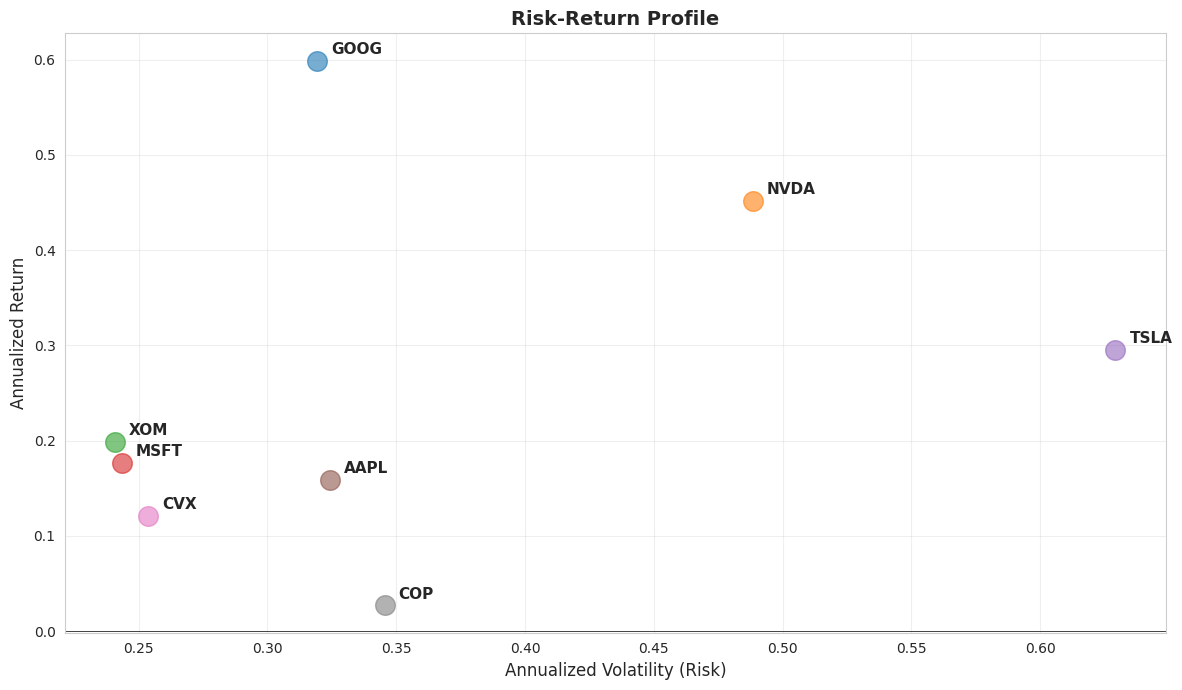

Stocks with higher return for a given risk (or lower risk for a given return) are more attractive
Points closer to the top-left are better on a risk-return basis


In [57]:
# Risk-return scatter plot
plt.figure(figsize=(12, 7))

# Plot each stock
for idx, row in risk_metrics.dropna(subset=['Ann_Volatility', 'Ann_Return']).iterrows():
    plt.scatter(row['Ann_Volatility'], row['Ann_Return'], s=200, alpha=0.6)
    plt.annotate(row['Stock'], (row['Ann_Volatility'], row['Ann_Return']),
                 xytext=(10, 5), textcoords='offset points', fontsize=11, fontweight='bold')

plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.title('Risk-Return Profile', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print("Stocks with higher return for a given risk (or lower risk for a given return) are more attractive")
print("Points closer to the top-left are better on a risk-return basis")

## 7. Monte Carlo Value-at-Risk Simulation

Building on our earlier analysis, we perform a comprehensive Monte Carlo simulation to estimate Value-at-Risk (VaR) for our portfolio. This method uses thousands of simulated price paths to determine potential losses.

### 7.1 Geometric Brownian Motion Simulation

We simulate NVIDIA (NVDA) stock price using the formula:
$$\Delta S = S(\mu\Delta t + \sigma \epsilon \sqrt{\Delta t})$$

Where μ is drift (mean return), σ is volatility, and ε is a random shock.

NVDA Parameters:
  Current Price: $184.86
  Daily Log Return (μ): 0.001316 (33.17% annualized)
  Daily Volatility (σ): 0.030894 (49.04% annualized)

Running 10,000 simulations for 252 days...


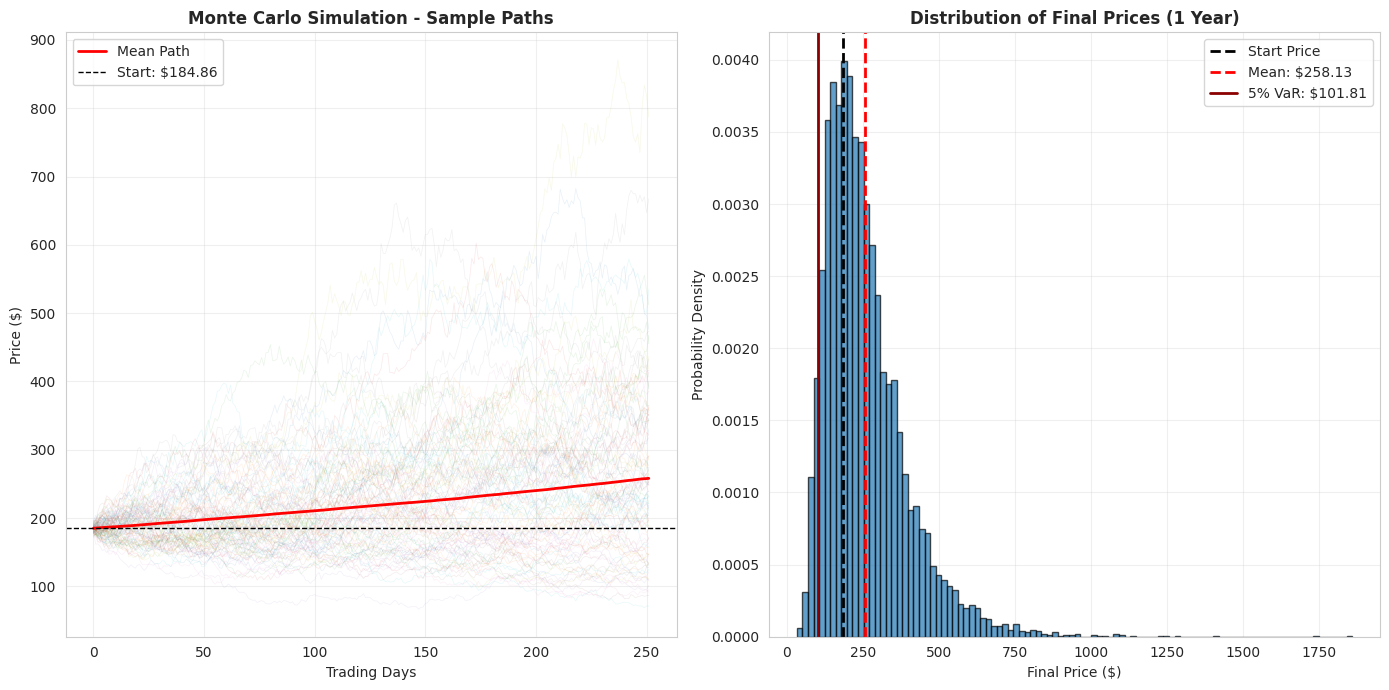


Simulation Results (1-year horizon):
  Mean Final Price: $258.13
  Median Final Price: $229.40
  Std Dev: $135.59
  5th Percentile (VaR): $101.81
  95th Percentile: $513.49

  Value at Risk (95% confidence):
    Maximum expected loss: $83.05 (44.9%)
    95% of simulations end with price >= $101.81

  Return-based VaR/CVaR (95%):
    VaR (5th pct return): -44.92%
    CVaR (avg return <= VaR): -54.31%


In [58]:
# Monte Carlo simulation for NVDA
nvda_log_returns = np.log(closing_prices['NVDA']).diff().dropna()
mu = nvda_log_returns.mean()
sigma = nvda_log_returns.std()
start_price = closing_prices['NVDA'].iloc[-1]

print(f"NVDA Parameters:")
print(f"  Current Price: ${start_price:.2f}")
print(f"  Daily Log Return (μ): {mu:.6f} ({mu*252:.2%} annualized)")
print(f"  Daily Volatility (σ): {sigma:.6f} ({sigma*np.sqrt(252):.2%} annualized)")

# Simulation function
def monte_carlo_simulation(start_price, mu, sigma, days, simulations):
    """Run Monte Carlo simulation for stock price"""
    results = np.zeros((simulations, days))

    for i in range(simulations):
        price = start_price
        for day in range(days):
            z = np.random.normal()
            price = price * np.exp((mu - 0.5 * sigma**2) + sigma * z)
            results[i, day] = price

    return results

# Run simulation
days = 252  # One year
num_simulations = 10000

print(f"\nRunning {num_simulations:,} simulations for {days} days...")
simulation_results = monte_carlo_simulation(start_price, mu, sigma, days, num_simulations)

# Visualize sample paths
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)

# Plot 100 random paths
sample_paths = simulation_results[np.random.choice(num_simulations, 100, replace=False)]
for path in sample_paths:
    plt.plot(range(days), path, alpha=0.1, linewidth=0.5)

plt.plot(range(days), simulation_results.mean(axis=0),
         color='red', linewidth=2, label='Mean Path')
plt.axhline(y=start_price, color='black', linestyle='--',
            linewidth=1, label=f'Start: ${start_price:.2f}')
plt.xlabel('Trading Days')
plt.ylabel('Price ($)')
plt.title('Monte Carlo Simulation - Sample Paths', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Distribution of final prices
plt.subplot(1, 2, 2)
final_prices = simulation_results[:, -1]
plt.hist(final_prices, bins=100, edgecolor='black', alpha=0.7, density=True)
plt.axvline(x=start_price, color='black', linestyle='--', linewidth=2, label='Start Price')
plt.axvline(x=final_prices.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: ${final_prices.mean():.2f}')

# Calculate VaR
var_95_price = np.percentile(final_prices, 5)
plt.axvline(x=var_95_price, color='darkred', linestyle='-', linewidth=2,
            label=f'5% VaR: ${var_95_price:.2f}')

plt.xlabel('Final Price ($)')
plt.ylabel('Probability Density')
plt.title('Distribution of Final Prices (1 Year)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate metrics
final_simple_returns = final_prices / start_price - 1
var_95_return = np.percentile(final_simple_returns, 5)
cvar_95_return = final_simple_returns[final_simple_returns <= var_95_return].mean()

print(f"\nSimulation Results (1-year horizon):")
print(f"  Mean Final Price: ${final_prices.mean():.2f}")
print(f"  Median Final Price: ${np.median(final_prices):.2f}")
print(f"  Std Dev: ${final_prices.std():.2f}")
print(f"  5th Percentile (VaR): ${var_95_price:.2f}")
print(f"  95th Percentile: ${np.percentile(final_prices, 95):.2f}")

print(f"\n  Value at Risk (95% confidence):")
print(f"    Maximum expected loss: ${start_price - var_95_price:.2f} ({((start_price - var_95_price)/start_price)*100:.1f}%)")
print(f"    95% of simulations end with price >= ${var_95_price:.2f}")

print(f"\n  Return-based VaR/CVaR (95%):")
print(f"    VaR (5th pct return): {var_95_return:.2%}")
print(f"    CVaR (avg return <= VaR): {cvar_95_return:.2%}")


## Methodological Limitations### General Limitations- Results are window-dependent (a single year can reflect a specific regime).- Monte Carlo assumptions (stylized return dynamics) may not fully capture jumps or crash behavior.- Directional prediction improvements are modest and may degrade out-of-sample.- Backtesting must remain strictly time-respecting to avoid look-ahead bias (walk-forward evaluation helps mitigate this).### Feature Engineering LimitationsThe technical indicators used (RSI, MACD, Bollinger Bands, momentum) are standard in financial education but have known limitations:- **Information redundancy**: These are simple transformations of price/volume data already available to the model- **Alpha decay**: Widely-known patterns documented in textbooks are typically highly competed away- **Retail focus**: Institutional quantitative firms use more sophisticated features:  - Market microstructure data (order flow, bid-ask dynamics)    - Alternative data sources (satellite imagery, transaction data)  - Proprietary features from statistical/information theory  - Cross-sectional factor exposures rather than individual stock signalsThis project demonstrates the **concepts** of momentum, volatility, and mean reversion, which remain relevant in finance. However, production quantitative systems would implement these more rigorously using:- Realized volatility estimators (not simple rolling windows)- Cross-sectional momentum ranks across universes- Statistically robust standardization methods- High-frequency microstructure featuresThe value of this analysis lies in demonstrating **proper methodology** (stationarity testing, walk-forward validation, avoiding look-ahead bias, honest evaluation of results) rather than in discovering a trading edge. These techniques are valuable for **learning quantitative workflows**, not for deployment in live trading.